# Разработка модели эффективного воспроизводства молочного стада хозяйства «Вольный луг»

## Описание проекта
По просьбе владелца молочного хозяйства «Вольный луг» необходимо разработать модель эффективного воспроизводства его молочного стада. Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».   \
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих бурёнок!
Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
1.	Первая будет прогнозировать возможный удой у коровы (целевой признак Удой)
2.	Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока)

С помощью модели нужно отобрать коров по двум критериям:  
- Средний удой за год — не менее 6000 килограммов
- Молоко должно быть вкусным

## Описание данных

Предоставлены данные о стаде фермера на текущий момент. Также предоставлены данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. 

`ferma_main.csv`  

`ferma_dad.csv`   

`cow_buy_old.csv`    

Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент. 

Описание таблицы: 

***Параметры корма коровы***
- `ЭКЕ (Энергетическая кормовая единица)` — измерение питательности корма коровы;
- `Сырой протеин` — содержание сырого протеина в корме, в граммах;
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.

***Где паслась корова***  
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.  

***Особенности коровы***  
- `id` — номер коровы;  
- `Порода` — порода коровы;  
- `Возраст` — бинарный признак (менее_2_лет, более_2_лет);  
- `Имя Папы` — порода папы коровы.    

***Характеристики молока***  
- `Жирность` — содержание жиров в молоке, в процентах;
- `Белок` — содержание белков в молоке, в процентах;
- `Вкус молока` — оценка вкуса по личным критериям фермера;
- `Удой` — масса молока, которую корова даёт в год, в килограммах.  

Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера.
Файл `cow_buy_old.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Структура таблицы почти аналогична `ferma_main.csv`, кроме нескольких особенностей:
- `Белок` и `Жирность` молока указаны на момент покупки — когда «ЭкоФерма» давала им свой корм.
- Параметры кормления `ЭКЕ`, `Сырой протеин`, `СПО` отсутствуют. Недавно технологи заказчика пересмотрели параметры корма и планируют их внедрить после расширения стада. Именно новые параметры нужно использовать, когда вы будете применять предсказательные модели к бурёнкам «ЭкоФермы». По новой схеме фермер планирует увеличить средние значения `ЭКЕ`, `Сырой протеин`, `СПО` на 5%.
- `Удой` и `Вкус молока` неизвестны — именно их и предстоит предсказать!

## План работы

- Загрузим и проанализируем предоставленные данные    
- Проведём иследования полученных данных с их визуализацией  
- Проведем корреляционный анализ  
- Решим задачу обучения модели линейной регрессии  
- Решим задачу обучения модели логистической регрессии  
- Сделаем итоговые выводы  

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
!pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, norm
from scipy import stats as st
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import phik

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
ferma_main.columns = ferma_main.columns.str.replace('_', ' ')
#ferma_main.columns = ferma_main.columns.str.lower()
ferma_main.head(10)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинные,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


***Наблюдаем не корректность в названиях столбцов. Целесообразно для наглядности сохранить русские названия. Приведем все названия с заглавной буквы и заменим нижнее подчеркивание на пробел. Будем исправлять неточности в значениях полученных данных.***

In [4]:
ferma_main.columns = ferma_main.columns.str.replace('порода папы быка', 'Порода папы быка')
print(*ferma_main.columns, sep="\n")

id
Удой, кг
ЭКЕ (Энергетическая кормовая единица)
Сырой протеин, г
СПО (Сахаро-протеиновое соотношение)
Порода
Тип пастбища
Порода папы быка
Жирность,%
Белок,%
Вкус молока
Возраст


In [5]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
ferma_dad.columns = ferma_dad.columns.str.replace('_', ' ')
#ferma_dad.columns = ferma_dad.columns.str.lower()
ferma_dad.head(10)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


In [6]:
ferma_dad.columns = ferma_dad.columns.str.replace('Имя Папы', 'Имя папы')
print(*ferma_dad.columns, sep="\n")

id
Имя папы


In [7]:
cow_buy = pd.read_csv('/datasets/cow_buy_old.csv', sep=';', decimal=',')
cow_buy.columns = cow_buy.columns.str.replace('_', ' ')
cow_buy.columns = cow_buy.columns.str.replace('Текущая жирность,%', 'Жирность,%')
cow_buy.columns = cow_buy.columns.str.replace('Текущий уровень белок,%', 'Белок,%')
#cow_buy.columns = cow_buy.columns.str.lower()
cow_buy.head(10)

,Порода,Тип пастбища,порода папы быка,Имя папы,"Жирность,%","Белок,%"
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079


In [8]:
cow_buy.columns = cow_buy.columns.str.replace('порода папы быка', 'Порода папы быка')
print(*cow_buy.columns, sep="\n")

Порода
Тип пастбища
Порода папы быка
Имя папы
Жирность,%
Белок,%


***Провели анализ полученных данных. Целесообразно внести корректность в названиях колонок и значених полученных данных.***

##  Шаг 2. Проведём предобработку данных

In [9]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   Порода папы быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [10]:
ferma_main.isna().sum()

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
Порода папы быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

In [11]:
ferma_main.duplicated().sum()

5

***Наблюдаем наличие дубликатов. Удаляем их.***

In [12]:
ferma_main[ferma_main.duplicated()]

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


***Наблюдаем наличие дубликатов коров с одинаковым `id`. Речь идет об одной и той же корове. Удаляем дубликаты.***

In [13]:
ferma_main.drop_duplicates(inplace=True)
ferma_main.duplicated().sum()

0

In [14]:
ferma_main['Порода'] = ferma_main['Порода'].replace('РефлешнСоверинг','Рефлешн Соверинг')
print(*ferma_main['Порода'].unique(), sep="\n")

Вис Бик Айдиал
Рефлешн Соверинг


***Изучив информацию о породах коров, пришли к заключению о необходимости внесении исправления в название породы.***
https://sibvest.elpub.ru/jour/article/view/587

In [15]:
print(*ferma_main['Тип пастбища'].unique(), sep="\n")

Равнинное
Равнинные
Холмистое


In [16]:
ferma_main['Тип пастбища'] = ferma_main['Тип пастбища'].replace('Равнинные','Равнинное')

In [17]:
print(*ferma_main['Тип пастбища'].unique(), sep="\n")

Равнинное
Холмистое


In [18]:
print(*ferma_main['Порода папы быка'].unique(), sep="\n")

Айдиал
Соверин
Айдиалл


In [19]:
ferma_main['Порода папы быка'] = ferma_main['Порода папы быка'].replace('Айдиалл','Айдиал')

In [20]:
print(*ferma_main['Порода папы быка'].unique(), sep="\n")

Айдиал
Соверин


In [21]:
ferma_main['Возраст'] = ferma_main['Возраст'].replace('более_2_лет','Более 2 лет')
ferma_main['Возраст'] = ferma_main['Возраст'].replace('менее_2_лет','Менее 2 лет')
print(*ferma_main['Возраст'].unique(), sep="\n")

Более 2 лет
Менее 2 лет


In [22]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [23]:
ferma_dad.isna().sum()

id          0
Имя папы    0
dtype: int64

In [24]:
ferma_dad.duplicated().sum()

0

In [25]:
print(*ferma_dad['Имя папы'].unique(), sep="\n")

Буйный
Соловчик
Барин
Геркулес


In [26]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Порода            20 non-null     object 
 1   Тип пастбища      20 non-null     object 
 2   Порода папы быка  20 non-null     object 
 3   Имя папы          20 non-null     object 
 4   Жирность,%        20 non-null     float64
 5   Белок,%           20 non-null     float64
dtypes: float64(2), object(4)
memory usage: 1.1+ KB


In [27]:
cow_buy.isna().sum()

Порода              0
Тип пастбища        0
Порода папы быка    0
Имя папы            0
Жирность,%          0
Белок,%             0
dtype: int64

In [28]:
cow_buy.duplicated().sum()

4

In [29]:
cow_buy[cow_buy.duplicated()]

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%"
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074


***Наблюдаем наличие буренок в ассоциации пастбищ "ЭкоФерма" с одинаковыми характеристиками. Оставляем их.***

In [30]:
cow_buy['Тип пастбища'] = cow_buy['Тип пастбища'].replace('равнинное','Равнинное')
cow_buy['Тип пастбища'] = cow_buy['Тип пастбища'].replace('холмистое','Холмистое')
print(*cow_buy['Тип пастбища'].unique(), sep="\n")

Холмистое
Равнинное


In [31]:
print(*cow_buy['Порода папы быка'].unique(), sep="\n")

Айдиал
Соверин


In [32]:
print(*cow_buy['Имя папы'].unique(), sep="\n")

Геркулес
Буйный
Барин
Соловчик


In [33]:
cow_buy['Порода'] = cow_buy['Порода'].replace('РефлешнСоверинг','Рефлешн Соверинг')
display(cow_buy)

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%"
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081
2,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.074
3,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.061
4,Рефлешн Соверинг,Равнинное,Айдиал,Буйный,3.64,3.074
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.053
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079
8,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.074
9,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.079


In [34]:
cow_buy.duplicated().sum()

4

In [35]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Порода            20 non-null     object 
 1   Тип пастбища      20 non-null     object 
 2   Порода папы быка  20 non-null     object 
 3   Имя папы          20 non-null     object 
 4   Жирность,%        20 non-null     float64
 5   Белок,%           20 non-null     float64
dtypes: float64(2), object(4)
memory usage: 1.1+ KB


***Было проведено исправление в названиях полученных данных. Удалены дубликаты. Пропуски в данных не наблюдаем.Проверели корректность типов данных.***

## Шаг 3. Проведём исследовательский анализ данных

***Проведем статистический анализ признаков и построим соответствующие графики.***

In [36]:
ferma_main.describe()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


In [37]:
ferma_dad.describe()

,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


In [38]:
cow_buy.describe()

,"Жирность,%","Белок,%"
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000


In [39]:
cow_buy.columns

Index(['Порода', 'Тип пастбища', 'Порода папы быка', 'Имя папы', 'Жирность,%',
       'Белок,%'],
      dtype='object')

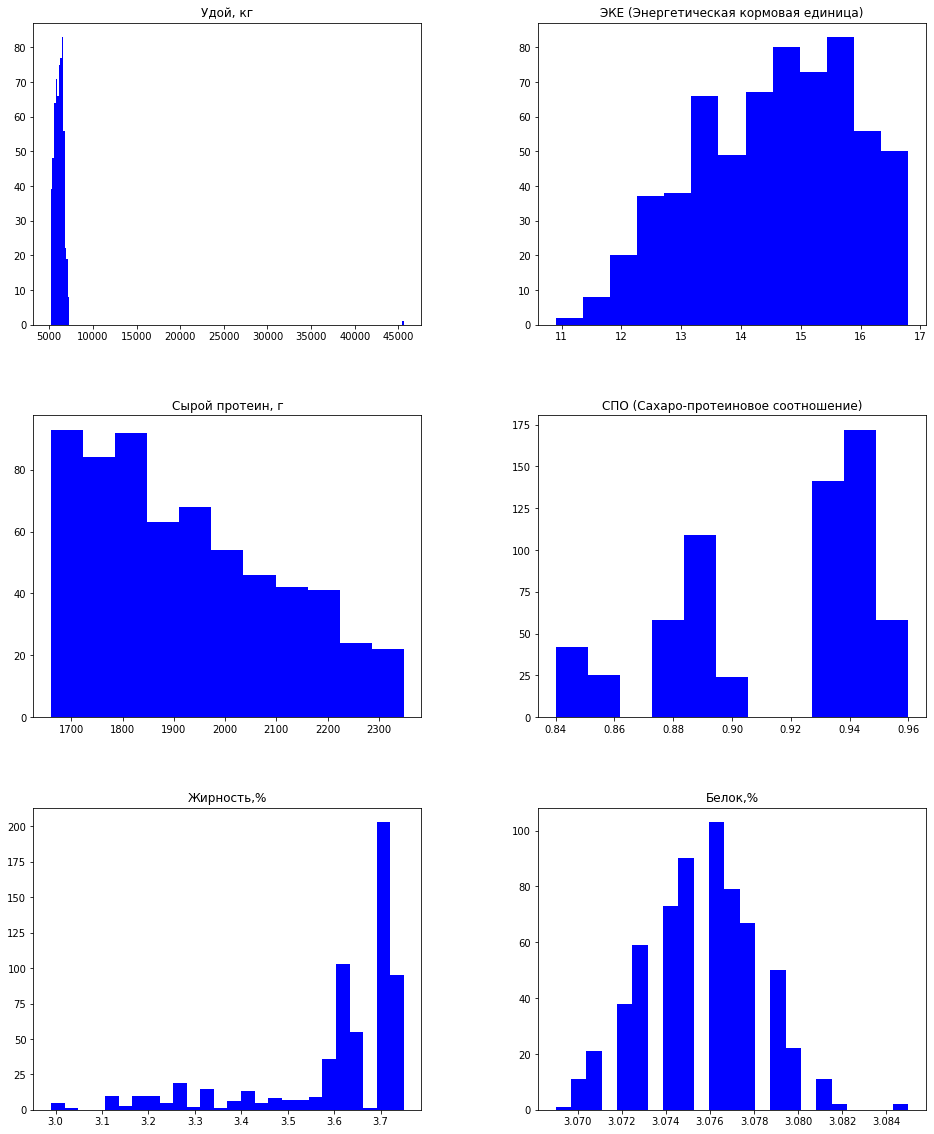

In [40]:
ferma_main[ferma_main.columns[ferma_main.columns != 'id']].hist(figsize=(16, 20), grid= False, color = 'blue', bins='auto');

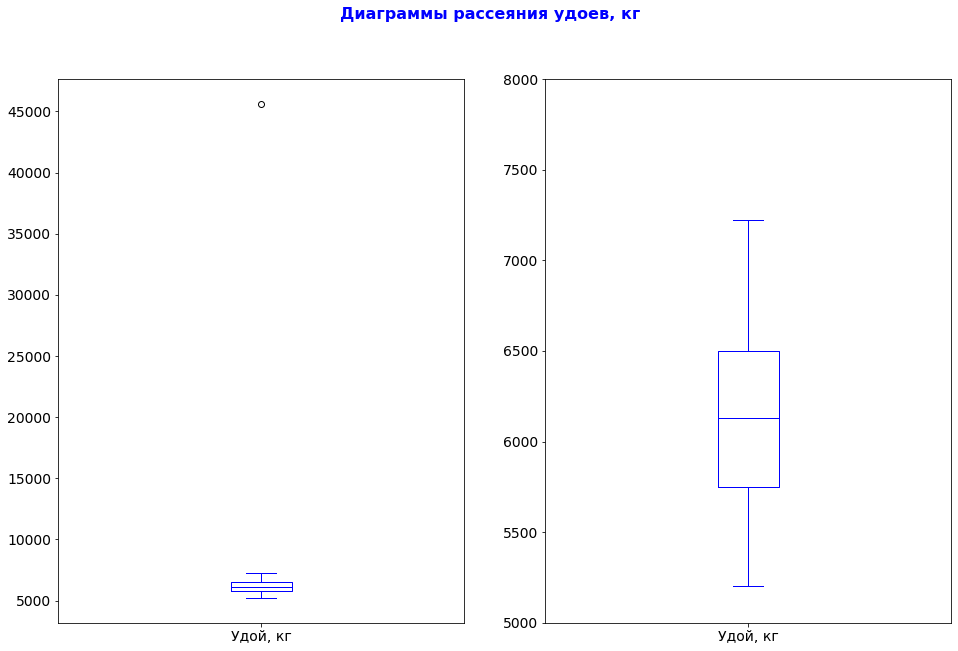

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))
ferma_main.boxplot(column=['Удой, кг'], grid= False, fontsize=14, color='blue', ax=axes[0])

ferma_main.boxplot(column=['Удой, кг'], grid= False, fontsize=14, color='blue', ax=axes[1])
axes[1].set_ylim(5000, 8000)

plt.suptitle(f'Диаграммы рассеяния удоев, кг', fontsize=16, fontweight="bold", color='blue')
plt.show()        

In [42]:
ferma_main[ferma_main['Удой, кг'] > 8000]

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,вкусно,Более 2 лет


In [43]:
ferma_main = ferma_main[ferma_main['Удой, кг'] < 8000]
ferma_main.describe()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670
std,181.475367,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.750000,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000
50%,315.500000,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.250000,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000
max,629.000000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


***Исследование показало наличие выбросов в значениях удоев. Аномалию удоляю.***

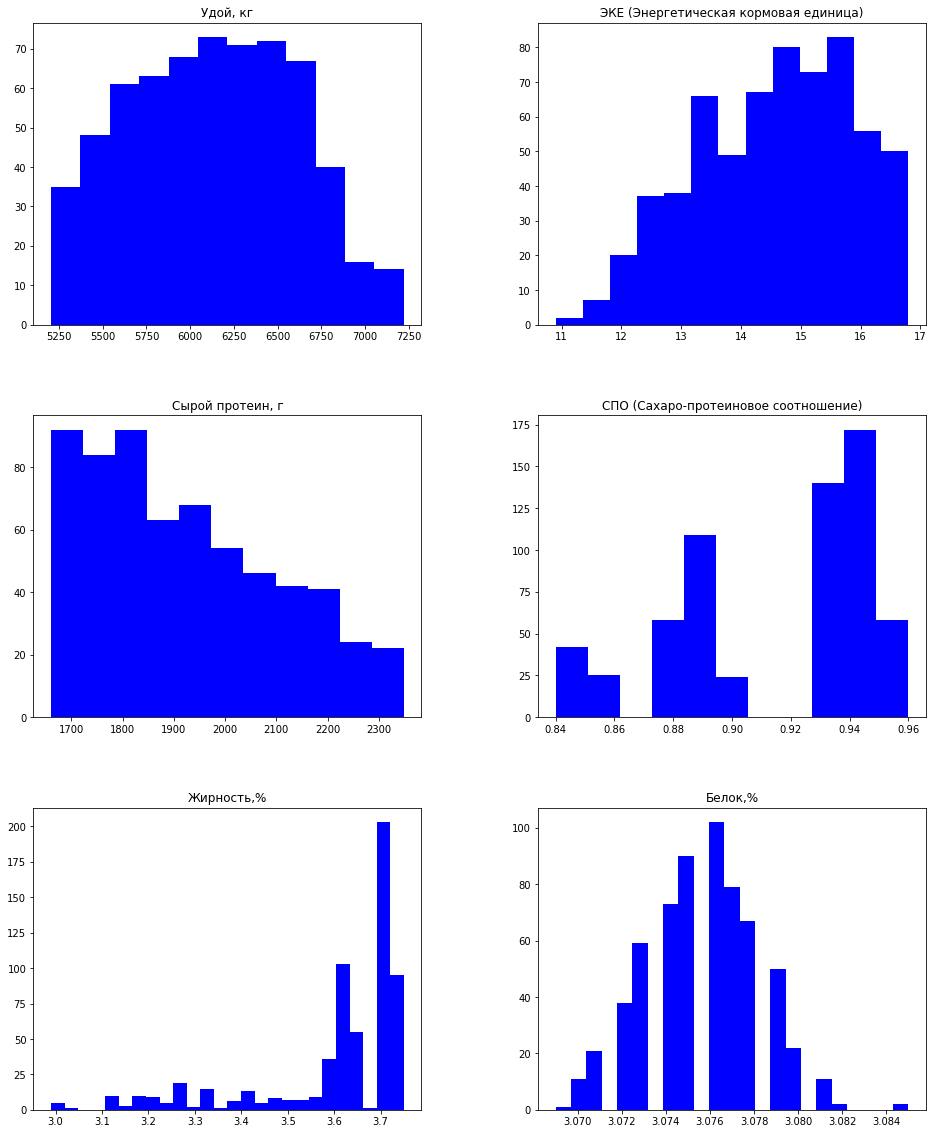

In [44]:
ferma_main[ferma_main.columns[ferma_main.columns != 'id']].hist(figsize=(16, 20), grid= False, color = 'blue', bins='auto');

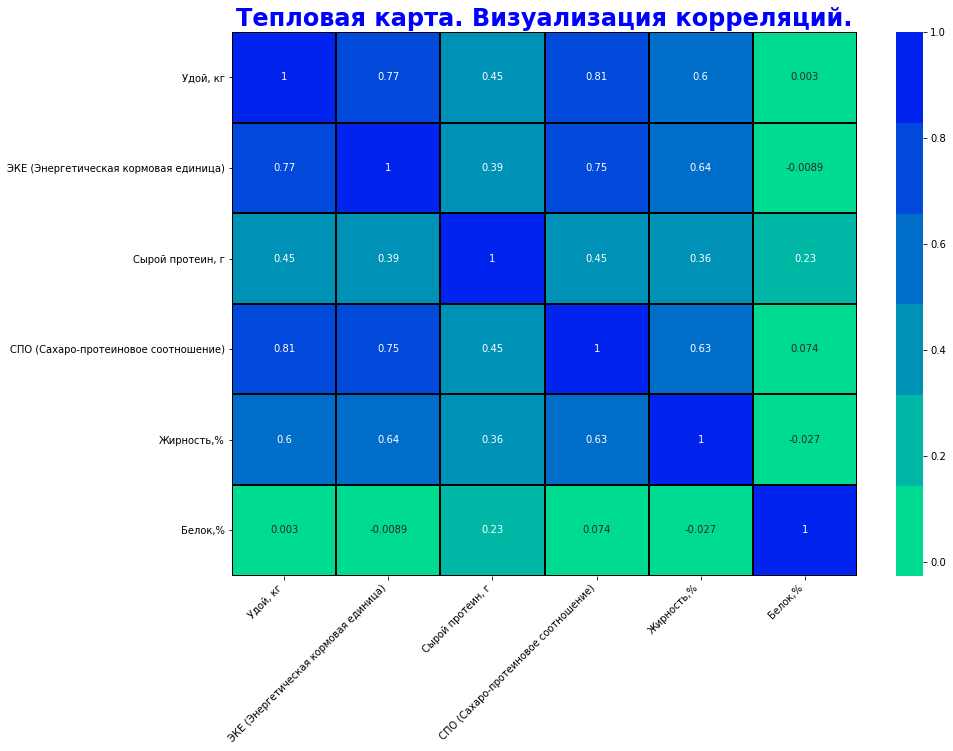

In [45]:
plt.figure(figsize=(14,10))
colormap = sns.color_palette("winter_r")
chart = sns.heatmap(ferma_main[ferma_main.columns[ferma_main.columns != 'id']].corr(), annot=True, 
            cmap=colormap, linewidths=1, linecolor='black')
plt.title('Тепловая карта. Визуализация корреляций.', fontsize=24, fontweight="bold", color='blue') 
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [46]:
def my_diagram(a, b, c, d, e):
    all = len(a)
    ferma_breed = a.groupby(b).size()/all
    ferma_breed_sort = ferma_breed.sort_values()
    schedule = ferma_breed_sort.plot(kind='barh', color='blue', figsize=(10,6))
    plt.title(f'{c}', fontsize=14, fontweight="bold", color='blue')
    plt.xlabel(f'{d}', fontsize=14, fontweight="bold", color='blue')
    plt.ylabel(f'{e}', fontsize=14, fontweight="bold", color='blue')
    
    percent = dict(ferma_breed_sort)
    row = 0
    i = 0
    for row in percent:
        schedule.text(percent[row]-0.09, i, str(round(percent[row]*100, 2)) + '%',
                      fontsize = 'large', fontweight='bold', color='white')
        i += 1

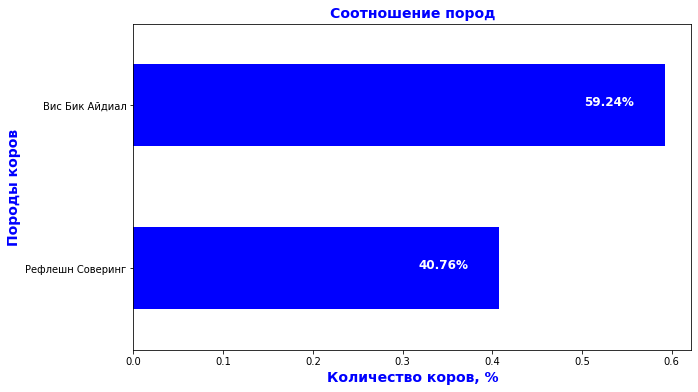

In [47]:
a=ferma_main
b='Порода'
c='Соотношение пород'
d='Количество коров, %'
e='Породы коров'
my_diagram(a, b, c, d, e)

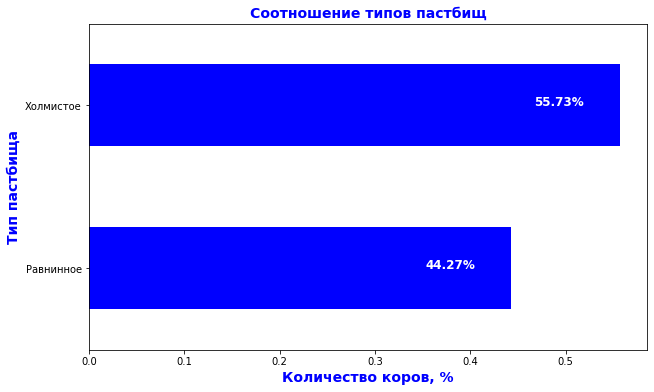

In [48]:
a=ferma_main
b='Тип пастбища'
c='Соотношение типов пастбищ'
d='Количество коров, %'
e='Тип пастбища'
my_diagram(a, b, c, d, e)

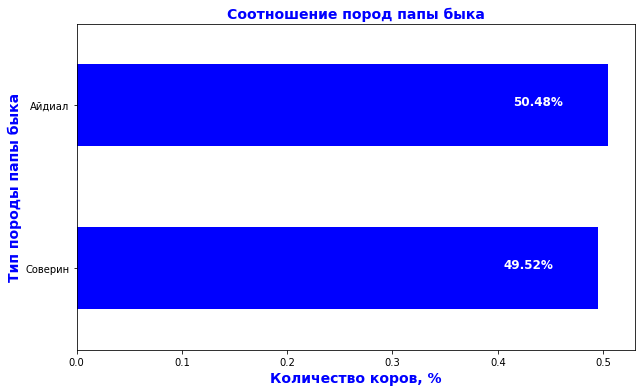

In [49]:
a=ferma_main
b='Порода папы быка'
c='Соотношение пород папы быка'
d='Количество коров, %'
e='Тип породы папы быка'
my_diagram(a, b, c, d, e)

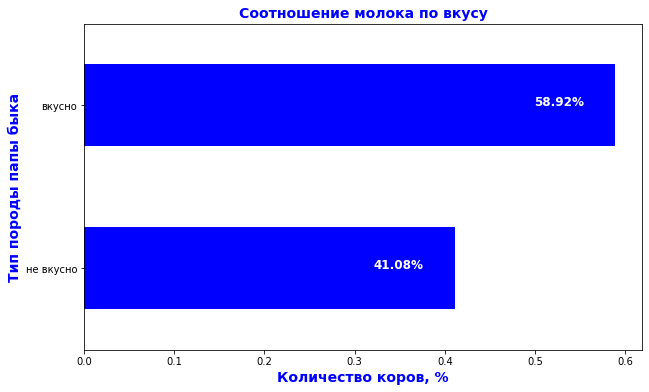

In [50]:
a=ferma_main
b='Вкус молока'
c='Соотношение молока по вкусу'
d='Количество коров, %'
e='Тип породы папы быка'
my_diagram(a, b, c, d, e)

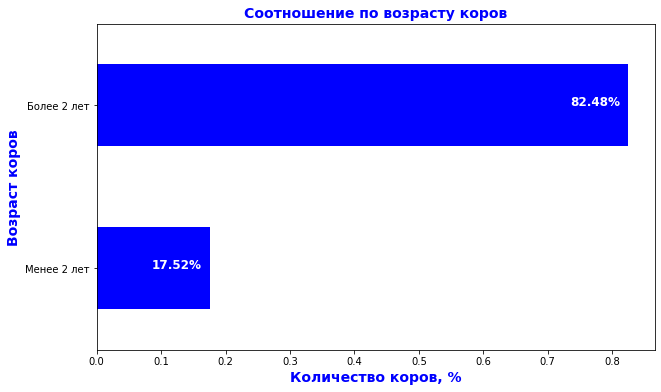

In [51]:
a=ferma_main
b='Возраст'
c='Соотношение по возрасту коров'
d='Количество коров, %'
e='Возраст коров'
my_diagram(a, b, c, d, e)

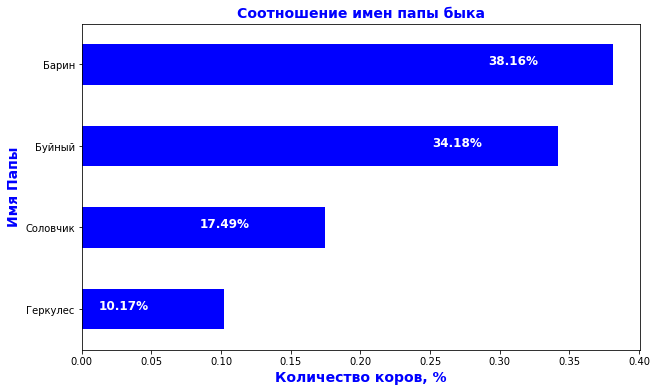

In [52]:
a=ferma_dad
b='Имя папы'
c='Соотношение имен папы быка'
d='Количество коров, %'
e='Имя Папы'
my_diagram(a, b, c, d, e)

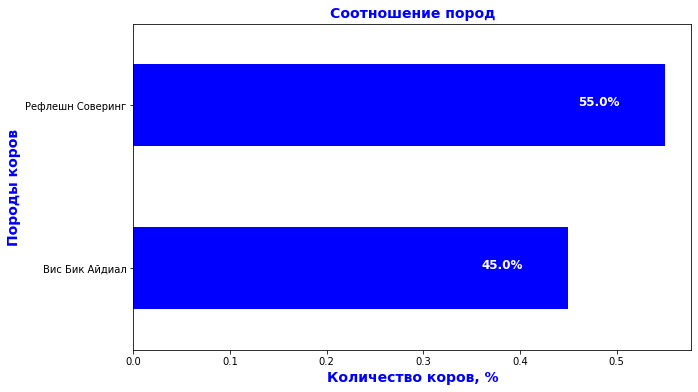

In [53]:
a=cow_buy
b='Порода'
c='Соотношение пород'
d='Количество коров, %'
e='Породы коров'
my_diagram(a, b, c, d, e)

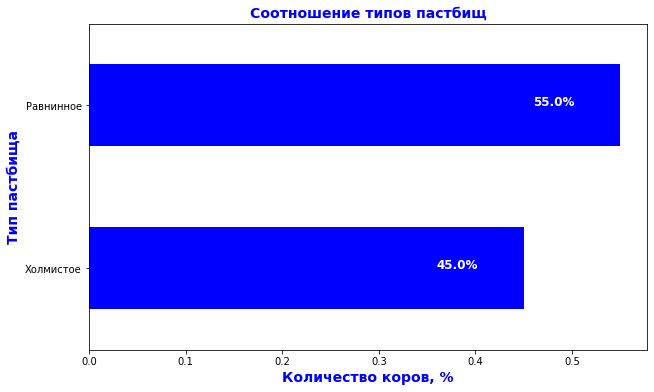

In [54]:
a=cow_buy
b='Тип пастбища'
c='Соотношение типов пастбищ'
d='Количество коров, %'
e='Тип пастбища'
my_diagram(a, b, c, d, e)

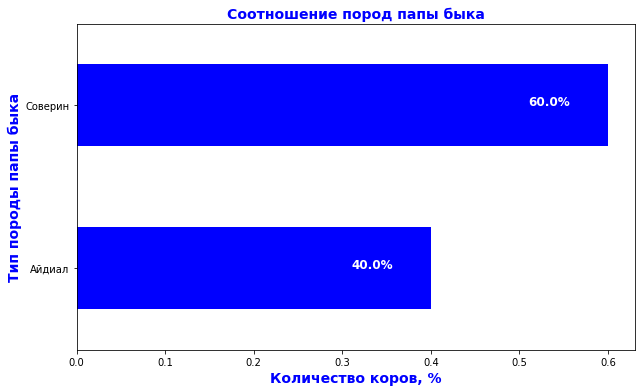

In [55]:
a=cow_buy
b='Порода папы быка'
c='Соотношение пород папы быка'
d='Количество коров, %'
e='Тип породы папы быка'
my_diagram(a, b, c, d, e)

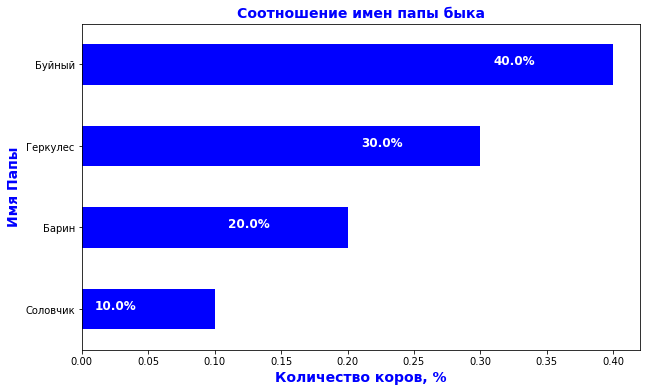

In [56]:
a=cow_buy
b='Имя папы'
c='Соотношение имен папы быка'
d='Количество коров, %'
e='Имя Папы'
my_diagram(a, b, c, d, e)

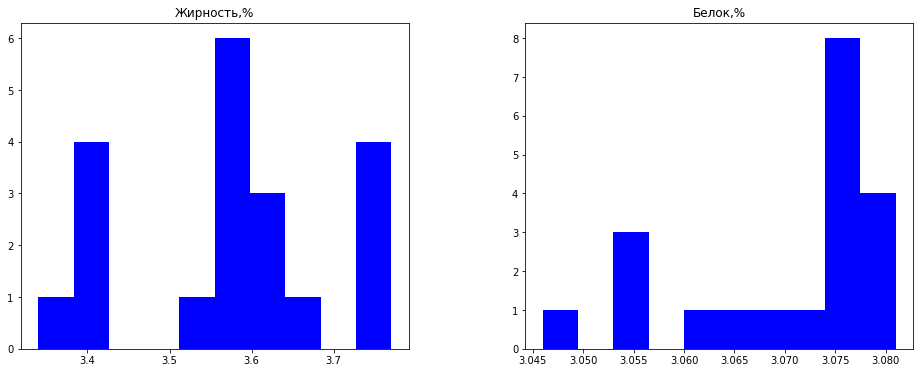

In [57]:
cow_buy[cow_buy.columns[cow_buy.columns != 'id']].hist(figsize=(16, 6), grid= False, color = 'blue');

***Провели визуализацию данных. Обнаружили выбросы и внесли исправления.***

## Шаг 4. Проведём корреляционный анализ

In [58]:
def my_corr_Pearson(a, b, c):

    a.plot(kind='scatter', x=b, y=c, ec='blue')
    corr1 = round(a[c].corr(a[b]),3)
    plt.xlabel(f'{b}\n\nКоэффициент корреляции Пирсона = {corr1}', fontsize=14, fontweight="bold", color='blue')
    plt.ylabel(f'{c}', fontsize=14, fontweight="bold", color='blue')
    plt.suptitle(f'Диаграммы рассеяния между\n {b} и {c}', fontsize=14, fontweight="bold", color='blue')

In [59]:
def my_corr_Spearman(a, b, c):

    a.plot(kind='scatter', x=b, y=c, ec='blue')
    corr_spearman, a_corr_spearman = spearmanr(a[b], a[c])
    plt.xlabel(f'{b}\n\nКоэффициент корреляции Спирмена = {round(corr_spearman,3)}\n\nзначение p = {a_corr_spearman}', 
               fontsize=14, fontweight="bold", color='blue')
    plt.ylabel(f'{c}', fontsize=14, fontweight="bold", color='blue')
    plt.suptitle(f'Диаграммы рассеяния между\n {b} и {c}', fontsize=14, fontweight="bold", color='blue')

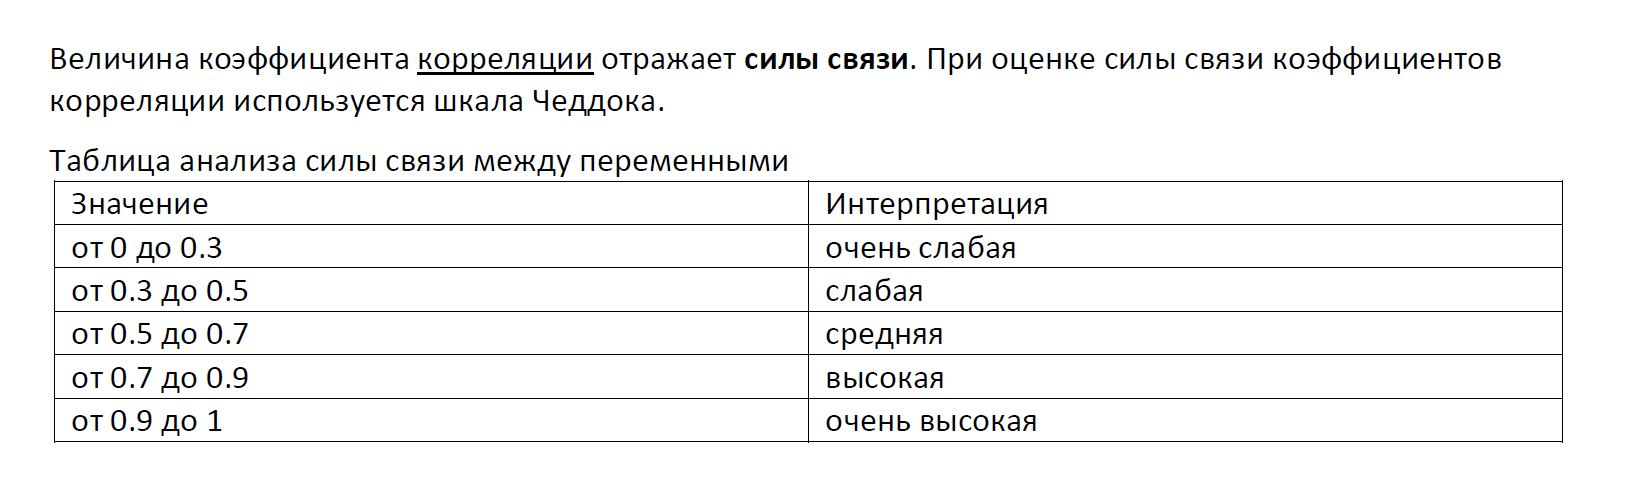

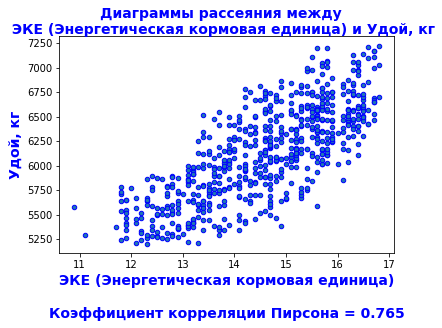

In [60]:
a=ferma_main
b='ЭКЕ (Энергетическая кормовая единица)'
c='Удой, кг'
my_corr_Pearson(a, b, c)

***Исследование показало высокую линейную связь между `ЭКЕ (Энергетическая кормовая единица)` и `Удоями`.***

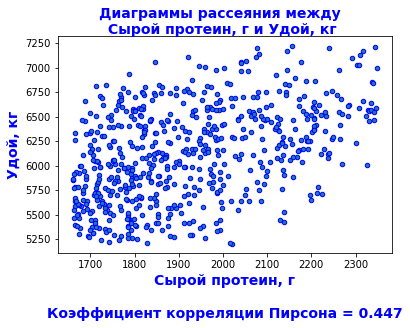

In [61]:
a=ferma_main
b='Сырой протеин, г'
c='Удой, кг'
my_corr_Pearson(a, b, c)

***Исследование показало слабую линейную связь между `Сырой протеин, г` и `Удоями`.***

***Воспольземся методом корреляции Спирмена. Этот статистический метод количественно определяет степень, в которой ранжированные переменные связаны монотонной функцией, что означает увеличение или уменьшение отношения. В качестве теста статистической гипотезы метод предполагает, что выборки некоррелированы (не отбрасывают <font size="4">_H₀_</font>).  
Функция принимает две действительные выборки в качестве аргументов и возвращает как коэффициент корреляции в диапазоне от -1 до 1, так и значение <font size="4">_p_</font> для интерпретации значимости коэффициента.***

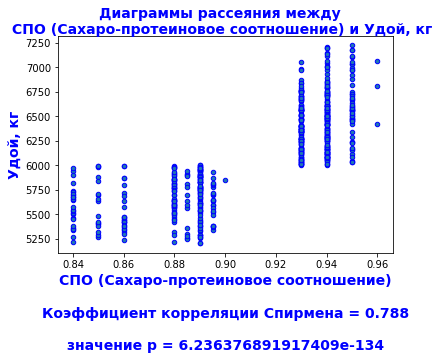

In [62]:
a=ferma_main
b='СПО (Сахаро-протеиновое соотношение)'
c='Удой, кг'
my_corr_Spearman(a, b, c)

***Статистический тест сообщает о высокой положительной корреляции со значением 0.787 Значение <font size="4">_p_</font> близко к нулю, что означает, что вероятность наблюдения данных при условии, что образцы не коррелированы, очень маловероятна (например, 95% достоверность), и что мы можем отвергнуть нулевую гипотезу, что образцы не коррелированы.***

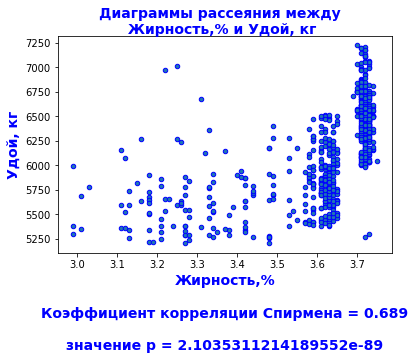

In [63]:
a=ferma_main
b='Жирность,%'
c='Удой, кг'
my_corr_Spearman(a, b, c)

***Статистический тест сообщает о средней положительной корреляции со значением 0.689 Значение <font size="4">_p_</font> близко к нулю, что означает, что вероятность наблюдения данных при условии, что образцы не коррелированы, очень маловероятна (например, 95% достоверность), и что мы можем отвергнуть нулевую гипотезу, что образцы не коррелированы.***

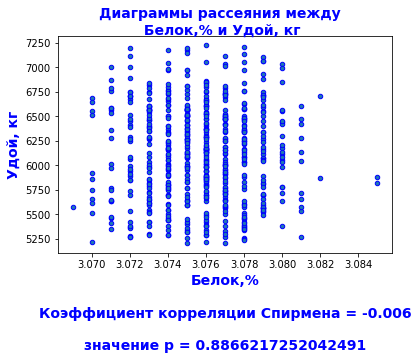

In [64]:
a=ferma_main
b='Белок,%'
c='Удой, кг'
my_corr_Spearman(a, b, c)

***Статистический тест сообщает об очень слабой отрицательной корреляции со значением -0.006. Значение <font size="4">_p_</font> не близко к нулю, что означает, что вероятность наблюдения данных при условии, что образцы не коррелированы, вероятна (например, 95% достоверность), и что мы не можем отвергнуть нулевую гипотезу, что образцы не коррелированы.***

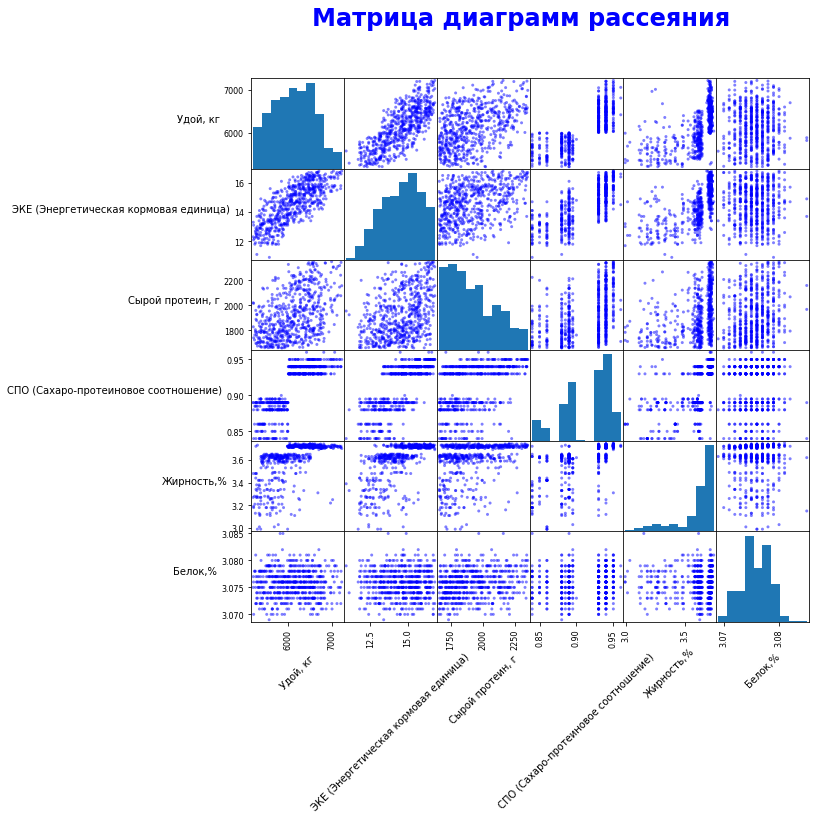

In [65]:
axes = pd.plotting.scatter_matrix(ferma_main[ferma_main.columns[ferma_main.columns != 'id']], figsize=(10, 10), color='blue')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Матрица диаграмм рассеяния', fontsize=24, fontweight="bold", color='blue')
plt.show()

***Выводы:***
- Исследование показало, что связь целевого признака `Удоя молока` линейная с признаками  `ЭКЕ (Энергетическая кормовая единица)` и `Сырой протеин, г`; 
- Связь целевого признака `Удоя молока` с другими признаками не линейная; 
- Мультиколинеарность не наблюдаем. Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0,9 до 0,95.

## Шаг 5. Проведём обучение модели линейной регрессии

***Построим модель линейной регрессии на данных датасета `farm_main.csv`. Используем в качестве целевого признак `Удой`.***

In [66]:
def func(a, b, c, d):   
    RANDOM_STATE = 42

    X = a.drop(b, axis=1)
    y = a[b]

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE)

    cat_col_names = c
    num_col_names = d

    encoder = OneHotEncoder(drop='first', sparse=False) 
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])

    encoder_col_names = encoder.get_feature_names() #get_feature_names_out()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
     
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    predictions = model_lr.predict(X_test)
    
    return [X_train, X_test, y_train, y_test, predictions, encoder, scaler, model_lr]

In [67]:
def R2_LinearRegression(func, a, b, c, d):   
    func_n = func(a, b, c, d)
    r2_lr = r2_score(func_n[3], func_n[4])
   
    print('\u001b[38;5;19m', 'R\u00B2 LinearRegression = ',r2_lr,'\u001b[0m')

In [68]:
def MSE_LinearRegression(func, a, b, c, d):   
    func_n = func(a, b, c, d)
    mse = mean_squared_error(func_n[3], func_n[4])
   
    print('\u001b[38;5;19m', 'MSE LinearRegression = ',mse ,'\u001b[0m')

In [69]:
def MAE_LinearRegression(func, a, b, c, d):   
    func_n = func(a, b, c, d)
    mae = mean_absolute_error(func_n[3], func_n[4])
   
    print('\u001b[38;5;19m', 'MAE LinearRegression = ',mae,'\u001b[0m')

In [70]:
def RMSE_LinearRegression(func, a, b, c, d):   
    func_n = func(a, b, c, d)
    rmse = mean_squared_error(func_n[3], func_n[4], squared=False)
   
    print('\u001b[38;5;19m', 'RMSE LinearRegression = ',rmse ,'\u001b[0m')

In [71]:
def training_model(func, a, b, c, d):
    func_n = func(a, b, c, d)
    residuals = func_n[3] - func_n[4] 
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
    axes[0].hist(residuals, bins=100, color = 'blue')
    axes[0].set_title('Гистограмма распределения остатков', fontsize=14, fontweight="bold", color='blue')
    axes[0].set_xlabel('Остатки', fontsize=14, fontweight="bold", color='blue')

    axes[1].scatter(x=func_n[4],  y=residuals, color = 'blue')
    axes[1].set_xlabel('Предсказания модели', fontsize=14, fontweight="bold", color='blue')
    axes[1].set_ylabel('Остатки', fontsize=14, fontweight="bold", color='blue')
    axes[1].set_title('Анализ дисперсии', fontsize=14, fontweight="bold", color='blue')
    plt.show()

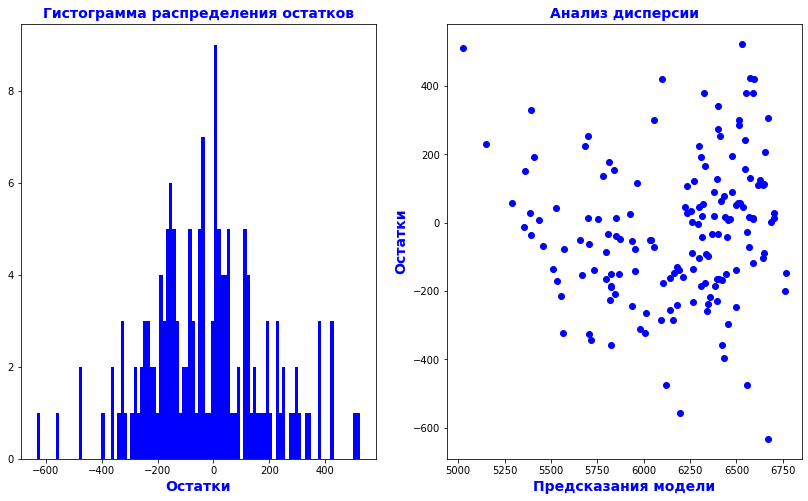

 R² LinearRegression =  0.7844078173416967 
 MSE LinearRegression =  43887.015009660514 
 MAE LinearRegression =  164.24194463474925 
 RMSE LinearRegression =  209.4922791170608 


In [72]:
a = ferma_main
b = 'Удой, кг'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
d = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)']
training_model(func, a, b, c, d)
R2_LinearRegression(func, a, b, c, d)
MSE_LinearRegression(func, a, b, c, d)
MAE_LinearRegression(func, a, b, c, d)
RMSE_LinearRegression(func, a, b, c, d)

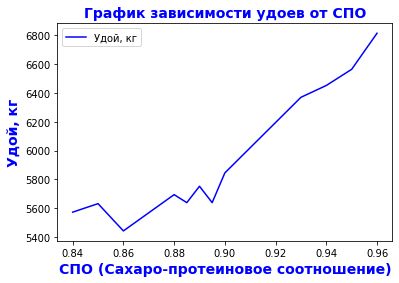

In [73]:
ferma_main.pivot_table(index='СПО (Сахаро-протеиновое соотношение)', values='Удой, кг', aggfunc='median').plot(color = 'blue')
plt.xlabel('СПО (Сахаро-протеиновое соотношение)', fontsize=14, fontweight="bold", color='blue')
plt.ylabel('Удой, кг', fontsize=14, fontweight="bold", color='blue')
plt.title('График зависимости удоев от СПО', fontsize=14, fontweight="bold", color='blue')
plt.show()

***Наблюдаем на графике зависимости целевого признака от `СПО (Сахаро-протеиновое соотношение)`. Определяем визуально, что значение 0.9 является границой нелинейности. Введем `СПО (Сахаро-протеиновое соотношение)` в котегориальный признак учтя полученное значение границы нелинейности.***

In [74]:
cpo_mean = ferma_main['СПО (Сахаро-протеиновое соотношение)'].mean()
ferma_main['СПО (Сахаро-протеиновое соотношение)'] = ferma_main['СПО (Сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.9 else 0)

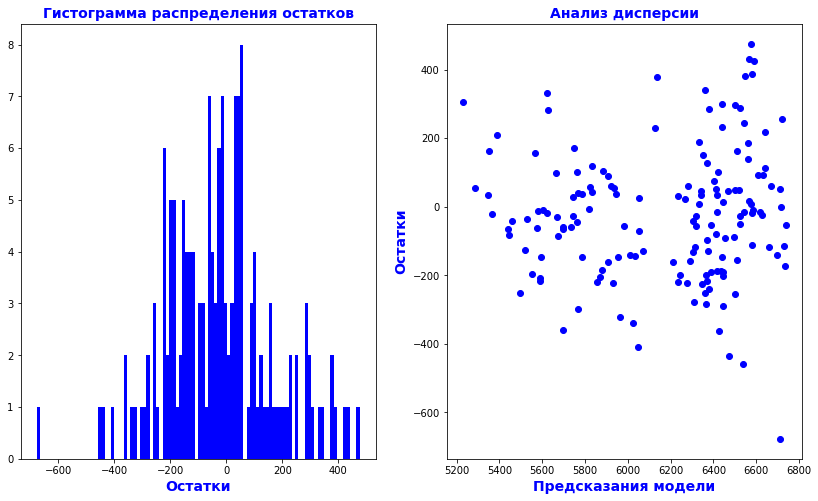

 R² LinearRegression =  0.8180879926867501 
 MSE LinearRegression =  37030.91131113695 
 MAE LinearRegression =  149.03965222364602 
 RMSE LinearRegression =  192.43417396901452 


In [75]:
ferma_main['ЭКЕ в квадрате'] = ferma_main['ЭКЕ (Энергетическая кормовая единица)']**2
a = ferma_main
b = 'Удой, кг'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО (Сахаро-протеиновое соотношение)']
d = ['ЭКЕ в квадрате', 'Сырой протеин, г']
training_model(func, a, b, c, d)
R2_LinearRegression(func, a, b, c, d)
MSE_LinearRegression(func, a, b, c, d)
MAE_LinearRegression(func, a, b, c, d)
RMSE_LinearRegression(func, a, b, c, d)

***Построим модель линейной регрессии с учетом нового признака `Имя папы` из файла `ferma_dad.csv` .***

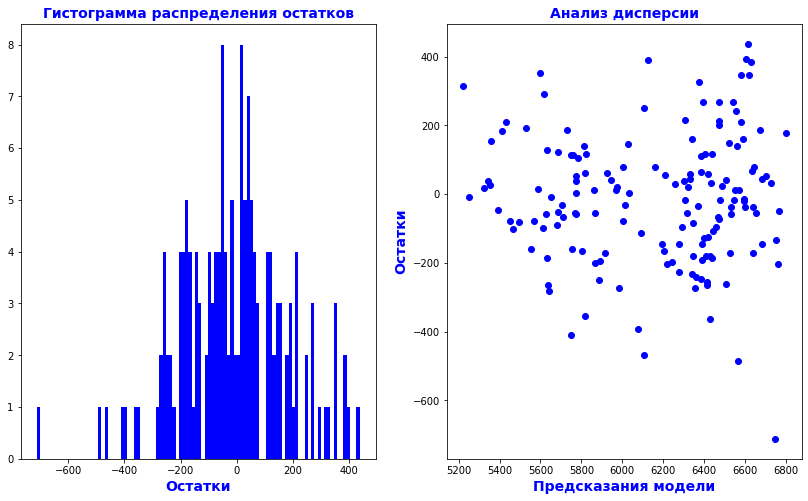

 R² LinearRegression =  0.8247542745210406 
 MSE LinearRegression =  35673.88988618195 
 MAE LinearRegression =  146.16302445362322 
 RMSE LinearRegression =  188.8753289505592 


In [76]:
ferma_main_dad = pd.merge(ferma_main, ferma_dad) 
a = ferma_main_dad
b = 'Удой, кг'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО (Сахаро-протеиновое соотношение)', 'Имя папы']
d = ['ЭКЕ в квадрате', 'Сырой протеин, г']
training_model(func, a, b, c, d)
R2_LinearRegression(func, a, b, c, d)
MSE_LinearRegression(func, a, b, c, d)
MAE_LinearRegression(func, a, b, c, d)
RMSE_LinearRegression(func, a, b, c, d)

***Исследование показало, что, сопоставив значения <font size="4">_R²_</font>, последняя модель является более точной. Значение <font size="4">_R²_</font> = 0.82 ближе к единице. Анализ данных других метрик <font size="4">_MSE, MAE, RMSE_</font> демонстрируют минимальное их значение в этой модели.***

In [77]:
cow_buy['ЭКЕ (Энергетическая кормовая единица)'] = ferma_main['ЭКЕ (Энергетическая кормовая единица)'].mean()*1.05
cow_buy['ЭКЕ в квадрате'] = cow_buy['ЭКЕ (Энергетическая кормовая единица)']**2
cow_buy['Сырой протеин, г'] = ferma_main['Сырой протеин, г'].mean()*1.05
cow_buy['СПО (Сахаро-протеиновое соотношение)'] = cpo_mean*1.05
cow_buy['Возраст'] = 'менее_2_лет'
cow_buy['Удой, кг'] = 0
cow_buy['СПО (Сахаро-протеиновое соотношение)'] = cow_buy['СПО (Сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.9 else 0)
cow_buy['Возраст'] = cow_buy['Возраст'].apply(lambda x: 1 if x == 'Более 2 лет' else 0)
display(cow_buy)

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Возраст,"Удой, кг"
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,15.276162,233.361138,2019.947532,1,0,0
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,15.276162,233.361138,2019.947532,1,0,0
2,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.074,15.276162,233.361138,2019.947532,1,0,0
3,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.061,15.276162,233.361138,2019.947532,1,0,0
4,Рефлешн Соверинг,Равнинное,Айдиал,Буйный,3.64,3.074,15.276162,233.361138,2019.947532,1,0,0
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.053,15.276162,233.361138,2019.947532,1,0,0
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,15.276162,233.361138,2019.947532,1,0,0
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,15.276162,233.361138,2019.947532,1,0,0
8,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.074,15.276162,233.361138,2019.947532,1,0,0
9,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.079,15.276162,233.361138,2019.947532,1,0,0


In [78]:
ferma_main_dad['Возраст'] = ferma_main_dad['Возраст'].apply(lambda x: 1 if x == 'Более 2 лет' else 0)
ferma_main_dad.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст,ЭКЕ в квадрате,Имя папы
0,1,5863,14.2,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,1,201.64,Буйный
1,2,5529,12.8,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,0,163.84,Соловчик
2,3,5810,14.0,1854,0,Рефлешн Соверинг,Холмистое,Соверин,3.59,3.074,не вкусно,1,196.00,Барин
3,4,5895,12.4,2012,0,Рефлешн Соверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,1,153.76,Буйный
4,5,5302,12.8,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,0,163.84,Барин


***Применим лучшую по качеству и по точности модель к данным из датасета `cow_buy_old.csv` мы спрогнозируем удой коров, которых фермер хочет приобрести у "Экофермы".***

In [79]:
X_train = ferma_main_dad
X_test = cow_buy

target = 'Удой, кг'
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО (Сахаро-протеиновое соотношение)', 'Имя папы']
num_col_names = ['ЭКЕ в квадрате', 'Сырой протеин, г']


X = X_train.drop(target, axis=1)
y = X_train[target]

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) 
X_ohe = encoder.fit_transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names() #get_feature_names_out()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)
                  
model_lr  = LinearRegression()
model_lr.fit(X, y) 

X = X_test.drop(target, axis=1)
y = X_test[target]

X_ohe = encoder.transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names() #get_feature_names_out()

X_scaled = scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X_cow = pd.concat([X_ohe, X_scaled], axis=1)   

predictions = model_lr.predict(X_cow)

cow_buy = cow_buy.reset_index(drop=True)
#print(predictions)

for i in range(len(cow_buy['Удой, кг'])):
    cow_buy.loc[i,'Удой, кг'] = predictions[i]
#cow_buy

display(cow_buy.sort_values(by = 'Удой, кг', ascending = False))  

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Возраст,"Удой, кг"
11,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.73,3.073,15.276162,233.361138,2019.947532,1,0,6370.5
17,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.77,3.053,15.276162,233.361138,2019.947532,1,0,6370.5
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.053,15.276162,233.361138,2019.947532,1,0,6370.5
3,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.061,15.276162,233.361138,2019.947532,1,0,6364.5
15,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.065,15.276162,233.361138,2019.947532,1,0,6364.5
9,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.079,15.276162,233.361138,2019.947532,1,0,6364.5
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,15.276162,233.361138,2019.947532,1,0,6359.5
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,15.276162,233.361138,2019.947532,1,0,6359.5
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,15.276162,233.361138,2019.947532,1,0,6359.5
18,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,15.276162,233.361138,2019.947532,1,0,6319.5


In [80]:
cow_buy.sort_values (by = ['Удой, кг'], ascending = False).loc[cow_buy['Удой, кг'] >= 6000]

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Возраст,"Удой, кг"
11,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.73,3.073,15.276162,233.361138,2019.947532,1,0,6370.5
17,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.77,3.053,15.276162,233.361138,2019.947532,1,0,6370.5
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.053,15.276162,233.361138,2019.947532,1,0,6370.5
3,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.061,15.276162,233.361138,2019.947532,1,0,6364.5
15,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.065,15.276162,233.361138,2019.947532,1,0,6364.5
9,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.079,15.276162,233.361138,2019.947532,1,0,6364.5
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,15.276162,233.361138,2019.947532,1,0,6359.5
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,15.276162,233.361138,2019.947532,1,0,6359.5
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,15.276162,233.361138,2019.947532,1,0,6359.5
18,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,15.276162,233.361138,2019.947532,1,0,6319.5


***Выводы:***
- Построены модели линейной регрессии на данных датасета `farm_main.csv` и определена по значениям метрик более точная;
- Полученное значение коэффициента детерминации <font size="4">_R²_</font> = 0.82, которая ближе к единице в более точной модели.
- Применена лучшая по качеству и по точности модель к данным из датасета `cow_buy_old.csv` и получен прогноз удоя коров.
- Определен прогноз коров с ассоциации пастбищ "ЭкоФерма" с удоем не менее 6000 кг в год.

## Шаг 6. Проведём обучение модели логистической регрессии

***Построим модель логистической регрессии на данных датасета `farm_main.csv`. Используем в качестве целевого признак `Вкус молока`. Построим матрицу ошибок.***

In [81]:
ferma_main['Возраст'] = ferma_main['Возраст'].apply(lambda x: 1 if x == 'Более 2 лет' else 0)
ferma_main['Вкус молока'] = ferma_main['Вкус молока'].apply(lambda x: 1 if x == 'вкусно' else 0)
cow_buy['Вкус молока'] = 0

 Accuracy =  0.6242038216560509 
 Precision =  0.6198347107438017 
 Recall =  0.8522727272727273 


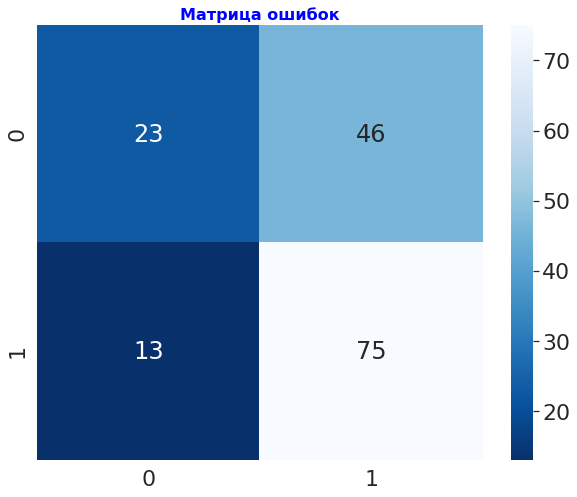

In [82]:
a = ferma_main
b = 'Вкус молока'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
d = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 
     'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%' , 'Белок,%']

RANDOM_STATE = 42

X = a.drop(b, axis=1)
y = a[b]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

cat_col_names = c
num_col_names = d

encoder = OneHotEncoder(drop='first', sparse=False) 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names() 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)  
precision = precision_score(y_test, y_pred) 
recall = recall_score(y_test, y_pred)       

plt.figure(figsize = (10,8))
cm = confusion_matrix(y_test, y_pred)

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.title('Матрица ошибок', fontsize=16, fontweight="bold", color='blue')
print('\u001b[38;5;19m', 'Accuracy = ',acc,'\u001b[0m')
print('\u001b[38;5;19m', 'Precision = ',precision,'\u001b[0m')
print('\u001b[38;5;19m', 'Recall = ',recall,'\u001b[0m')

***Проведенный анализ показал, что значение Recall=0.85 больше Precision=0.62. Критичнее всего при покупке коров ложно-положительная ошибка. Сейчас модель допускает ошибку первого рода в 46 случаях. Рассчитаем метрики для случая, когда критическая ошибка будет равна 0.*** 

In [83]:
a = ferma_main
b = 'Вкус молока'
c = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
d = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 
     'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%' , 'Белок,%']

RANDOM_STATE = 42

X = a.drop(b, axis=1)
y = a[b]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

cat_col_names = c
num_col_names = d

encoder = OneHotEncoder(drop='first', sparse=False) 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names() 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)  

y_proba = clf.predict_proba(X_test)[:,1]  #[:,1] > porog     #cow_buy['pred_proba'] = clf.predict_proba(X_cow)[:,1] > 0.66

data = pd.DataFrame(zip(y_test, y_proba, y_pred), columns = ['y_valid', 'y_proba', 'y_pred']).sort_values(by='y_proba',ascending=False)

display(data) 

,y_valid,y_proba,y_pred
66,1,0.835375,1
85,1,0.834565,1
51,1,0.831855,1
110,1,0.824944,1
146,1,0.814454,1
...,...,...,...
23,1,0.310728,0
144,0,0.293429,0
119,0,0.284055,0
141,0,0.280745,0


In [84]:
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 2000,endpoint=False)]

In [85]:
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x>= i else 0)

display(data.head())

,y_valid,y_proba,y_pred,y_pred_0.1,y_pred_0.11,y_pred_0.12,y_pred_0.13,y_pred_0.14,y_pred_0.15,y_pred_0.16,...,y_pred_0.91,y_pred_0.92,y_pred_0.93,y_pred_0.94,y_pred_0.95,y_pred_0.96,y_pred_0.97,y_pred_0.98,y_pred_0.99,y_pred_1.0
66,1,0.835375,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
85,1,0.834565,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
51,1,0.831855,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
110,1,0.824944,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
146,1,0.814454,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [86]:
for i in thresholds:
    cm = confusion_matrix(y_test, data['y_pred_'+str(i)])
    if cm[0][1] == 0:
        print('\u001b[38;5;19m', 'Порог = ',i ,'Precision = ', round(precision_score(y_test, data['y_pred_'+str(i)]), 2), 'TP =', cm[1][1])
        porog = i
        break

 Порог =  0.83 Precision =  1.0 TP = 3


 Accuracy =  0.46 
 Precision =  1.0 
 Recall =  0.03 


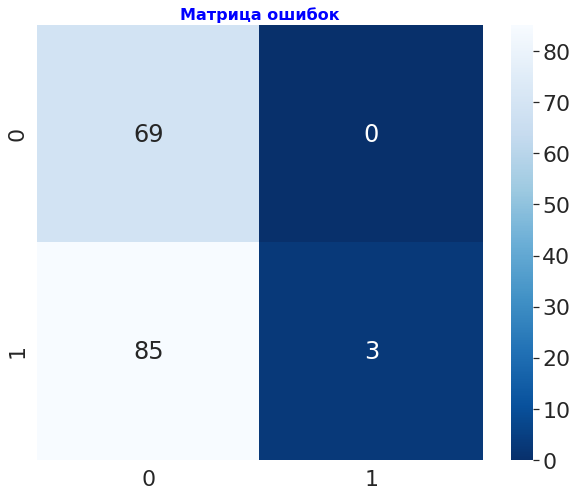

In [87]:
acc = round(accuracy_score(y_test, data['y_pred_'+str(porog)]), 2)
precision = round(precision_score(y_test, data['y_pred_'+str(porog)]), 2)
recall = round(recall_score(y_test, data['y_pred_'+str(porog)]), 2)

plt.figure(figsize = (10,8))
cm = confusion_matrix(y_test, data['y_pred_'+str(porog)])

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.title('Матрица ошибок', fontsize=16, fontweight="bold", color='blue')
print('\u001b[38;5;19m', 'Accuracy = ',acc,'\u001b[0m')
print('\u001b[38;5;19m', 'Precision = ',precision,'\u001b[0m')
print('\u001b[38;5;19m', 'Recall = ',recall,'\u001b[0m')         

In [88]:
X_train = ferma_main_dad
X_test = cow_buy

target = 'Вкус молока'
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
num_col_names = ['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 
     'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%' , 'Белок,%']

X = X_train.drop(target, axis=1)
y = X_train[target]

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_ohe = encoder.fit_transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X = pd.concat([X_ohe, X_scaled], axis=1)
                  
clf = LogisticRegression()
clf = clf.fit(X, y)

X = X_test.drop(target, axis=1)
y = X_test[target]

X_ohe = encoder.transform(X[cat_col_names])

encoder_col_names = encoder.get_feature_names()

X_scaled = scaler.transform(X[num_col_names])

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)

X_cow = pd.concat([X_ohe, X_scaled], axis=1)   


y_pred = clf.predict_proba(X_cow)[:,1] 

cow_buy['y_pred'] = y_pred

cow_buy['Вкус молока'] = cow_buy['y_pred'].apply(lambda x: 'вкусно' if x > porog else 'не вкусно')      
cow_buy['Возраст'] = cow_buy['Возраст'].apply(lambda x: 'более 2 лет' if x == 1 else 'менее 2 лет')

cow_buy = cow_buy.sort_values(by = ['y_pred'], ascending = False)
cow_buy = cow_buy.drop(columns='y_pred') 

display(cow_buy)

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Возраст,"Удой, кг",Вкус молока
17,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.77,3.053,15.276162,233.361138,2019.947532,1,менее 2 лет,6370.5,вкусно
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.053,15.276162,233.361138,2019.947532,1,менее 2 лет,6370.5,вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,15.276162,233.361138,2019.947532,1,менее 2 лет,6359.5,вкусно
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,15.276162,233.361138,2019.947532,1,менее 2 лет,6138.0,не вкусно
3,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.061,15.276162,233.361138,2019.947532,1,менее 2 лет,6364.5,не вкусно
18,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,15.276162,233.361138,2019.947532,1,менее 2 лет,6319.5,не вкусно
11,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.73,3.073,15.276162,233.361138,2019.947532,1,менее 2 лет,6370.5,не вкусно
15,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.065,15.276162,233.361138,2019.947532,1,менее 2 лет,6364.5,не вкусно
2,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.074,15.276162,233.361138,2019.947532,1,менее 2 лет,6085.5,не вкусно
8,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.074,15.276162,233.361138,2019.947532,1,менее 2 лет,6085.5,не вкусно


***Наблюдаем при пороге 0.83 нулевое значение критической ошибки 1-го рода FP. При этом значение равное 3 принимает количество истинно-положительного результата.***

***Самое оптимальное значение порога — <font size="4">0.83</font>. При минимальном значении критической ошибки мы получаем 3 коровы как количество истинно-положительного результата целевого признака вкуса молока.***

***Покажем список коров с ассоциации пастбищ "ЭкоФерма" с признаком по вкусу молока "вкусно".***

In [89]:
cow_buy.loc[cow_buy['Вкус молока'] == 'вкусно']

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Возраст,"Удой, кг",Вкус молока
17,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.77,3.053,15.276162,233.361138,2019.947532,1,менее 2 лет,6370.5,вкусно
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.053,15.276162,233.361138,2019.947532,1,менее 2 лет,6370.5,вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,15.276162,233.361138,2019.947532,1,менее 2 лет,6359.5,вкусно


## Шаг 7. Итоговые выводы

***Учитвая полученные ранее данные с коровами по годовому удою выше 6000 кг и с признаком по вкусу молоко "вкусно" объеденим эти данные.***

In [90]:
cow_buy.sort_values (by = ['Удой, кг'], ascending = False).loc[(cow_buy['Удой, кг'] >= 6000) & 
                                                               (cow_buy['Вкус молока'] == 'вкусно')]

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",ЭКЕ (Энергетическая кормовая единица),ЭКЕ в квадрате,"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Возраст,"Удой, кг",Вкус молока
17,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.77,3.053,15.276162,233.361138,2019.947532,1,менее 2 лет,6370.5,вкусно
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.053,15.276162,233.361138,2019.947532,1,менее 2 лет,6370.5,вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,15.276162,233.361138,2019.947532,1,менее 2 лет,6359.5,вкусно


***Проведенный анализ показал, что 3 коровы удовлетворяют требованиями фермера для приобритения этих буренок.*** 
- В процессе обучения модели линейной ригреесси и построения более точной модели, мы воспользовалдись добавлением нового признака. Перевели `СПО (Сахаро-протеиновое соотношение)` в категориальный признак, выявив и использовав границу нелинейности. Ввели новый признак `ЭКЕ в квадрате`. Данная модель была более точной, чем предыдущая. 
- Далее дополнительно ввели в категориальный признак  `Имя папы`. Данная модель показала максимальную точность. На основе этой модели строили прогноз по удоям буренок ассоциации пастбищ "ЭкоФерма". 
- Построили модель логистической регрессии на данных датасета farm_main.csv. Получили данные по целевому признаку `Вкус молока`. Выявили список коров со вкусным молоком. 
- Объеденили полученняе данные и выявили перечень из 3 коров с удовлетворяющими для заказчика требованиями по удоям годовых более 6000 кг и со вкусным молоком.
- Самое оптимальное значение порога — 0.83. При минимальном значении критической ошибки мы получаем 3 коровы как количество истинно-положительного результата целевого признака вкуса молока.
- Фермер, учитывая свои требования к объему удоев и качеству молока, может купить 3 коровы из стада с минимальным риском для себя.